In [2]:
import numpy as np
import xarray as xr

import os

orig_pkg = os.environ.get("PKG_CONFIG_PATH", "")
orig_ld = os.environ.get("LD_LIBRARY_PATH", "")

print(orig_pkg)
print(orig_ld)

os.environ["PKG_CONFIG_PATH"] = "/orcd/data/faez/001/DARPA_2D/env_add/ifen_new_2/lib/pkgconfig" + ":" + os.environ.get("PKG_CONFIG_PATH","")
os.environ["LD_LIBRARY_PATH"] = "/orcd/data/faez/001/DARPA_2D/env_add/ifen_new_2/lib" + ":" + os.environ.get("LD_LIBRARY_PATH","")
# now import dolfin


In [3]:
import numpy as np
import xarray as xr

import os
from dolfin import *


from mmdisk.fea.fenics.utils import get_loadfunc, get_time_list_alt
from mmdisk.fea.common import create_time_points
from mmdisk.fea.fenics.mesh import mesh_and_properties, mesh2d_and_properties
from mmdisk.fea.fenics.incremental import incremental_cyclic_fea
from mmdisk.fea.common import default_cycle

import matplotlib.pyplot as plt

/Users/shen/miniconda3/envs/fenics_legacy/lib/python3.13/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
def cal_principal_strain(eps):
    eps_r  = eps[:,:,0]
    eps_th  = eps[:,:,1]
    eps_z  = eps[:,:,2]
    eps_rz  = eps[:,:,3]
    eps1 = (eps_r + eps_z)/2 + np.sqrt((eps_r-eps_z)**2/4.+eps_rz**2)
    eps2 = eps_th
    eps3 = (eps_r + eps_z)/2 - np.sqrt((eps_r-eps_z)**2/4.+eps_rz**2)
    eps_PI = np.concatenate((eps1[:,:,None],eps2[:,:,None],eps3[:,:,None]),axis=-1)
    return eps_PI

def max_principal(eps_PI):
    eps1 = eps_PI.max(axis=-1)
    return eps1

def max_shear(eps_PI):
    eps1 = eps_PI.max(axis=-1)
    eps3 = eps_PI.min(axis=-1)
    gamma = eps1-eps3
    return gamma

def Brown_Miller(eps_PI):
    eps1 = eps_PI.max(axis=-1)
    eps3 = eps_PI.min(axis=-1)
    gamma = eps1-eps3
    epsN = (eps1+eps3)/2.
    return gamma + epsN

def von_Mises(eps_PI):
    eps_VM = np.sqrt(2/9.*((eps_PI[:,:,0]-eps_PI[:,:,1])**2 + 
                           (eps_PI[:,:,1]-eps_PI[:,:,2])**2 +
                           (eps_PI[:,:,2]-eps_PI[:,:,0])**2))
    return eps_VM

def cal_strain_range(strain,period,n_cyc):
    strain_max = [strain[i*period:(i+1)*period+1].max(axis=0) for i in range(n_cyc)]
    strain_min = [strain[i*period:(i+1)*period+1].min(axis=0) for i in range(n_cyc)]
    strain_range = (np.array(strain_max)-np.array(strain_min))/2.
    return strain_range

def fatigue_criter_range(eps,n_cyc,criter='all'):
    assert int((eps.shape[0] - 1)/n_cyc) == (eps.shape[0] - 1)/n_cyc
    period = int((eps.shape[0] - 1)/n_cyc)
    eps_PI = cal_principal_strain(eps)
    if criter == 'max_princicpal':
        strain = max_principal(eps_PI)
        return cal_strain_range(strain,period,n_cyc)
    if criter == 'max_shear':
        strain = max_shear(eps_PI)
        return cal_strain_range(strain,period,n_cyc)
    if criter == 'Brown_Miller':
        strain = Brown_Miller(eps_PI)
        return cal_strain_range(strain,period,n_cyc)
    if criter == 'von_Mises':
        strain = von_Mises(eps_PI)
        return cal_strain_range(strain,period,n_cyc)
    if criter == 'all':
        strain1 = max_principal(eps_PI)
        strain2 = max_shear(eps_PI)
        strain3 = Brown_Miller(eps_PI)
        strain4 = von_Mises(eps_PI)
        return (cal_strain_range(strain1,period,n_cyc), 
                cal_strain_range(strain2,period,n_cyc), 
                cal_strain_range(strain3,period,n_cyc),
                cal_strain_range(strain4,period,n_cyc))

In [4]:
disks2d = xr.open_zarr("one_disk_with_full_fgm_comp_prop_1000_Cre_calib_rev_fix_chunk_1_for_fea.zarr")

In [ ]:
a_disk['property'].values.tolist()

In [104]:
picked_disk = disks2d.isel(disks=0).copy()

In [109]:
picked_disk.sel(property="Young's Modulus").values

<bound method Mapping.values of <xarray.Dataset> Size: 2MB
Dimensions:                (y_pixel: 64, x_pixel: 256, point: 415, element: 11)
Coordinates:
  * point                  (point) int64 3kB 0 1 2 3 4 5 ... 410 411 412 413 414
  * element                (element) object 88B 'Ti_mass_fraction' ... 'C_mas...
    disks                  int64 8B 0
  * x_pixel                (x_pixel) float64 2kB 0.00025 0.00075 ... 0.1278
  * y_pixel                (y_pixel) float64 512B 0.00025 0.00075 ... 0.03175
    property               <U15 60B "Young's Modulus"
Data variables: (12/21)
    fgm_comp1              (y_pixel, x_pixel) float64 131kB ...
    rI                     float64 8B ...
    zI                     float64 8B ...
    fgm_comp2              (y_pixel, x_pixel) float64 131kB ...
    to                     float64 8B ...
    tI                     float64 8B ...
    ...                     ...
    elemental_composition  (y_pixel, x_pixel, element) float64 1MB ...
    zH           

In [89]:

def fatigue_para(disk_index, omega_input, DT_input, n_cycles = 10):
    import numpy as np
    mesh, props = mesh_and_properties(disks2d.isel(disks=disk_index).load())
    omega = omega_input
    T_load = DT_input
    t_heatdwell = 20.0
    t_cooldwell = 1500.  # cooling dwell time
    skip_cold = False  # skip the cold dwell for the thermal problem

    l_cycle = default_cycle.copy()
    l_cycle[1] = t_heatdwell
    l_cycle[3] = t_cooldwell

    time_division =  [0.25, 0.25, 0.25, 0.25]

    time_steps = l_cycle.copy() * time_division

    load = get_loadfunc(T_load, l_cycle)

    n_cycles = 10

    # t_fine = l_cycle[:3].sum() + l_cycle[2]
    period, _, t_output = create_time_points(n_cycles, l_cycle, output_division=2.0)
    t_list = get_time_list_alt(l_cycle, time_steps, n_cycles, skip_cold=skip_cold)

    tvec, outputs, flag = incremental_cyclic_fea(
        mesh,
        props,
        load,
        omega,
        t_list,
        t_output,
        period,
        Displacement_BC="fix-free",
        plastic_inverval=1,
        skip_cold=skip_cold,
        outputs={"PEEQ": np.zeros((len(t_output), mesh.num_cells()+20)), 
                "u": np.zeros((len(t_output), mesh.num_vertices()+20, 2)),
                "strain": np.zeros((len(t_output), mesh.num_cells()+20, 4))
                },
    )

    max_Princ,max_Shear,BM,VM = fatigue_criter_range(outputs["strain"],n_cycles)


    PEEQ = outputs["PEEQ"][4::8][:]
    d_PEEQ = np.diff(PEEQ, axis=0) 
    d_PEEQ_lastcycle = d_PEEQ[-1,:]
    d_PEEQ_lastcycle_max = d_PEEQ_lastcycle.max()

    if d_PEEQ_lastcycle_max < 2e-5:
        Status = 'SDEL'
        print("Elastic or Shakedown!")
    else:
        d_VM = np.diff(VM, axis=0)
        d_VM_lastcycle = d_VM[-1,:]
        d_VM_lastcycle_max = d_VM_lastcycle.max()
        if d_VM_lastcycle_max >= 2e-5:
            Status = 'RAT'
            print("Ratchetting")
        else:
            Status = 'AP'
            print("Alternating Plasticity")


    import numpy as np
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(5, 3))

    x = 1 + np.arange(n_cycles)

    for name, arr in zip(["Max. principal strain", "Max. shear strain", "Brown-Miller", "von Mises Eq. strain"], 
                        [max_Princ, max_Shear, BM, VM]):
        col_idx = arr[-1, :].argmax() 
        ax.plot(x, arr[:, col_idx], label=name) 

    ax.set_xlabel("Cycle")
    ax.set_ylabel("Fatigue damage parameter")
    ax.set_title(r"$\omega$=" + str(int(omega)) + " rad/s, $T$=" + str(int(T_load)) + " K, " + Status, size=10)


    handles, labels = ax.get_legend_handles_labels()
    order = ["Brown-Miller", "Max. shear strain", "Max. principal strain", "von Mises Eq. strain"]
    handles = [handles[labels.index(o)] for o in order]
    labels  = order
    ax.legend(handles, labels)

    plt.show()

    # fig = plt.gcf()
    # fig.set_size_inches(5, 3)
    fig.tight_layout()
    fig.savefig(str(disk_index) + '_' + str(int(omega)) + '_' + str(int(T_load)) + '_' + Status + '.png')

Alternating Plasticity


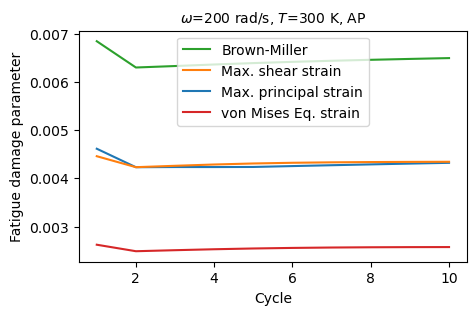

In [80]:
fatigue_para(407, 200.0, 300.0)

In [92]:
mesh, props = mesh_and_properties(disks2d.isel(disks=0).load())
omega = 100
T_load = 200
t_heatdwell = 20.0
t_cooldwell = 1500.  # cooling dwell time
skip_cold = False  # skip the cold dwell for the thermal problem

l_cycle = default_cycle.copy()
l_cycle[1] = t_heatdwell
l_cycle[3] = t_cooldwell

time_division =  [0.25, 0.25, 0.25, 0.05]

time_steps = l_cycle.copy() * time_division

load = get_loadfunc(T_load, l_cycle)

n_cycles = 10

# t_fine = l_cycle[:3].sum() + l_cycle[2]
period, _, t_output = create_time_points(n_cycles, l_cycle, output_division=2.0)
t_list = get_time_list_alt(l_cycle, time_steps, n_cycles, skip_cold=skip_cold)

In [93]:
t_list

array([0.000000e+00, 2.500000e-01, 5.000000e-01, 7.500000e-01,
       1.000000e+00, 6.000000e+00, 1.100000e+01, 1.600000e+01,
       2.100000e+01, 2.175000e+01, 2.250000e+01, 2.325000e+01,
       2.400000e+01, 9.900000e+01, 1.740000e+02, 2.490000e+02,
       3.240000e+02, 3.990000e+02, 4.740000e+02, 5.490000e+02,
       6.240000e+02, 6.990000e+02, 7.740000e+02, 8.490000e+02,
       9.240000e+02, 9.990000e+02, 1.074000e+03, 1.149000e+03,
       1.224000e+03, 1.299000e+03, 1.374000e+03, 1.449000e+03,
       1.524000e+03, 1.524250e+03, 1.524500e+03, 1.524750e+03,
       1.525000e+03, 1.530000e+03, 1.535000e+03, 1.540000e+03,
       1.545000e+03, 1.545750e+03, 1.546500e+03, 1.547250e+03,
       1.548000e+03, 1.623000e+03, 1.698000e+03, 1.773000e+03,
       1.848000e+03, 1.923000e+03, 1.998000e+03, 2.073000e+03,
       2.148000e+03, 2.223000e+03, 2.298000e+03, 2.373000e+03,
       2.448000e+03, 2.523000e+03, 2.598000e+03, 2.673000e+03,
       2.748000e+03, 2.823000e+03, 2.898000e+03, 2.9730

In [91]:
t_output

array([0.00000e+00, 5.00000e-01, 1.00000e+00, 1.10000e+01, 2.10000e+01,
       2.25000e+01, 2.40000e+01, 7.74000e+02, 1.52400e+03, 1.52450e+03,
       1.52500e+03, 1.53500e+03, 1.54500e+03, 1.54650e+03, 1.54800e+03,
       2.29800e+03, 3.04800e+03, 3.04850e+03, 3.04900e+03, 3.05900e+03,
       3.06900e+03, 3.07050e+03, 3.07200e+03, 3.82200e+03, 4.57200e+03,
       4.57250e+03, 4.57300e+03, 4.58300e+03, 4.59300e+03, 4.59450e+03,
       4.59600e+03, 5.34600e+03, 6.09600e+03, 6.09650e+03, 6.09700e+03,
       6.10700e+03, 6.11700e+03, 6.11850e+03, 6.12000e+03, 6.87000e+03,
       7.62000e+03, 7.62050e+03, 7.62100e+03, 7.63100e+03, 7.64100e+03,
       7.64250e+03, 7.64400e+03, 8.39400e+03, 9.14400e+03, 9.14450e+03,
       9.14500e+03, 9.15500e+03, 9.16500e+03, 9.16650e+03, 9.16800e+03,
       9.91800e+03, 1.06680e+04, 1.06685e+04, 1.06690e+04, 1.06790e+04,
       1.06890e+04, 1.06905e+04, 1.06920e+04, 1.14420e+04, 1.21920e+04,
       1.21925e+04, 1.21930e+04, 1.22030e+04, 1.22130e+04, 1.221

In [ ]:
# eps = [eps_rr, eps_theta, eps_zz, eps_rz]


In [ ]:
ps_PI = cal_principal_strain(eps)
strain = max_principal(ps_PI)

In [46]:

period = 8
np.array([strain[i*period:(i+1)*period+1].max(axis=0) for i in range(n_cycles)]).shape

(10, 5316)

In [47]:
max_Princ.shape

(10, 5316)

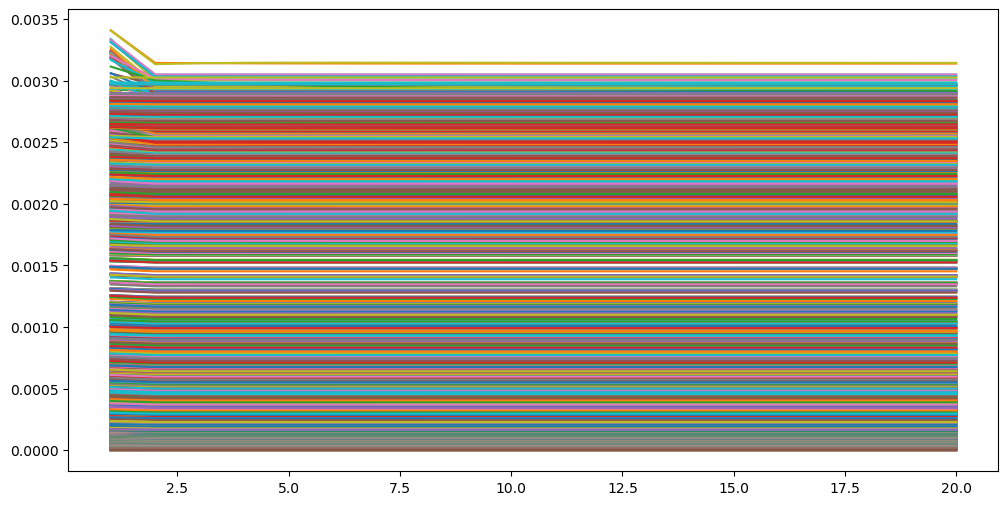

Text(0.5, 1.0, 'Max PEEQ over time with skip_cold=True')

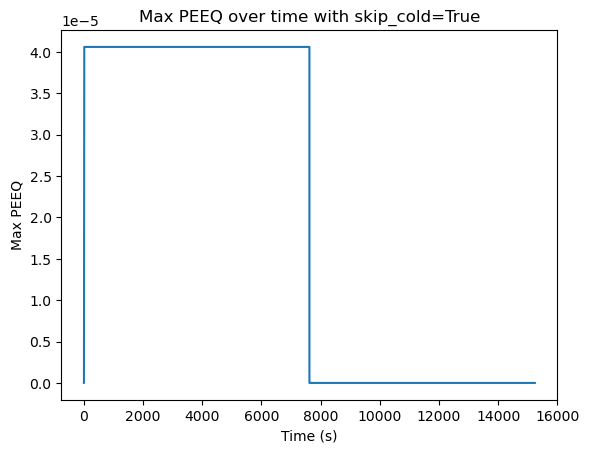

In [73]:
plt.plot(tvec, outputs["PEEQ"].max(axis=1), label="With skip_cold=True")
#plt.plot(tvec, orig_peeq.max(axis=1), label="Without skip_cold", linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Max PEEQ")
plt.title("Max PEEQ over time with skip_cold=True")

In [4]:
mesh, props, pvmesh = mesh2d_and_properties(disks2d.isel(disks=0).load(), return_pyvista=True)
pvmesh

UnstructuredGrid (0x16c2c2740)
  N Cells:    11352
  N Points:   5974
  X Bounds:   2.750e-02, 1.340e-01
  Y Bounds:   0.000e+00, 2.950e-02
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   8